In [1]:
%matplotlib inline
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import json
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from opto_untils import session_dirs
from plot_untils import shiftedColorMap, template_reorder
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps


# Create a white-to-bright red colormap
colors = [(1, 1, 1), (1, 0, 0)]  # white to red
my_red = LinearSegmentedColormap.from_list("white_to_red", colors)

In [2]:
session_id = 'behavior_717121_2024-06-15_10-00-58'
session_dir = session_dirs(session_id)

In [3]:
opto_df = pd.read_csv(session_dir['opto_csv_file'])
sites = np.sort(opto_df['site'].unique())
sites = [int(i) for i in sites]
emission_loc = opto_df['emission_location'].unique()
powers = np.sort(opto_df['power'].unique())
powers = [float(i) for i in powers]
num_pulses = np.sort(opto_df['num_pulses'].unique())
num_pulses = [int(i) for i in num_pulses]
freqs = opto_df['param_group'].unique()
freqs = [int(re.search(r'train(.*?)Hz', freq).group(1)) for freq in freqs]
opto_df['freq'] = opto_df['param_group'].apply(lambda x: int(re.search(r'train(.*?)Hz', x).group(1)))
durations = np.sort(opto_df['duration'].unique())
durations = [float(i) for i in durations]
print('Sites:')
print(sites)
print('Emission locations:')
print(emission_loc)
print('Powers:')
print(powers)
print('Freqs:')
print(freqs)
print('Pulse durations:')
print(durations)
print('Num pulses:')
print(num_pulses)

stim_params = {'sites': list(sites), 
                'emission_loc': list(emission_loc),
                'powers': list(powers), 
                'freqs': list(freqs),
                'durations': list(durations),
                'num_pulses': list(num_pulses)
                }

Sites:
[0]
Emission locations:
['surface_LC' 'surface_PrL' 'surface_S1' 'surface_V1']
Powers:
[5.0, 10.0, 20.0, 30.0, 50.0]
Freqs:
[5]
Pulse durations:
[4.0, 5.0]
Num pulses:
[5]


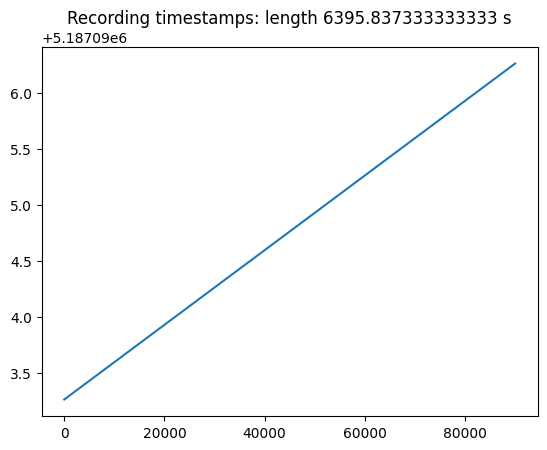

In [4]:
# load opto events time
laser_line = 2
# load neuralpixel session
session = Session(session_dir['session_dir'])
# session = Session('/root/capsule/data/behavior_717121_2024-06-15_10-00-58/ecephys/ecephys_clipped')
recording = session.recordnodes[0].recordings[0]
timestamps = recording.continuous[0].timestamps
fig = plt.Figure(figsize=(10,2))
plt.plot(timestamps[:30000*3])
plt.title(f'Recording timestamps: length {len(timestamps)/30000} s')
plt.show()

Processor ID: 100, Stream Name: ProbeA, Line: 1 (main sync line))
  First event sample number: 20250610
  Last event sample number: 67468820
  Total sync events: 2925
  Sample rate: 30000.0
Processor ID: 103, Stream Name: PXIe-6341, Line: 1 (aux sync line))
  First event sample number: 20270569
  Last event sample number: 67457485
  Total sync events: 2925
  Scale factor: 0.9999016962122516
  Actual sample rate: 30002.949403569997


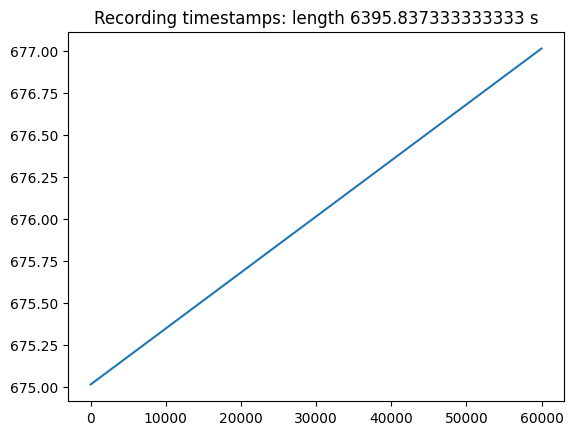

In [5]:
# if needs re-alignment
ignore_after_time = 60*60 # seconds
recording.add_sync_line(1,            # TTL line number
                        100,          # processor ID
                        'ProbeA',  # stream name
                        main=True,    # set as the main stream
                        ignore_intervals = [(ignore_after_time * 30000, np.inf)])    

# recording.add_sync_line(1,            # TTL line number                                       
#                         100,          # processor ID
#                         'ProbeA-LFP', # stream name
#                         ignore_intervals = [(ignore_after_time * 2500, np.inf)])

recording.add_sync_line(1,            # TTL line number
                        103,          # processor ID
                        'PXIe-6341',   # stream name
                        ignore_intervals = [(ignore_after_time * 30000, np.inf)])

recording.compute_global_timestamps(overwrite=True)

timestamps = recording.continuous[0].timestamps
fig = plt.Figure(figsize=(10,2))
plt.plot(timestamps[:30000*2])
plt.title(f'Recording timestamps: length {len(timestamps)/30000} s')
plt.show()

NameError: name 'opto_df' is not defined

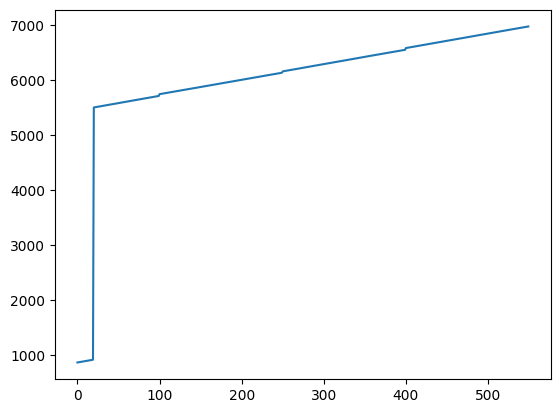

In [4]:
# extract laser times
events = recording.events
laser_events = events[
                (events.stream_name == 'PXIe-6341')
                & (events.line == laser_line)
                & (events.state == 1)
            ].sort_values(by='sample_number')
laser_times = np.sort(laser_events['timestamp'].values)
fig = plt.Figure(figsize=(6,3))
plt.plot(laser_times)
plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_events)}')

In [ ]:
# adjustment
laser_times = laser_times[1:]
fig = plt.Figure(figsize=(6,3))
plt.plot(laser_times)
plt.title(f'Total trigger: {len(opto_df)}; Total recorded: {len(laser_times)}')

In [ ]:
# load quality metrics from nwb
nwb = load_nwb(session_dir['nwb_dir'])
unit_qc = nwb.units[:][['ks_unit_id', 'isi_violations_ratio', 'firing_rate', 'presence_ratio', 'amplitude_cutoff', 'decoder_label']]
unit_wf = nwb.units[:][['ks_unit_id', 'waveform_mean', 'waveform_sd']]

In [ ]:
# load sample number from sorting results
sorting = si.load_extractor(session_dir['curated_dir'])
unit_ids = sorting.get_unit_ids()
unit_spikes = [timestamps[sorting.get_unit_spike_train(unit_id)] for unit_id in unit_ids]
unit_spikes = {unit_id:unit_spike for unit_id, unit_spike in zip(unit_ids, unit_spikes)}

In [ ]:
# opto tagging for each unit
opto_df['time'] = laser_times

In [ ]:
# opto tagging for each unit
opto_df['time'] = laser_times
opto_df.to_csv(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_session.csv'), index=False)
resp_win = 15/1000 # seconds
opto_info = stim_params
opto_info['dimensions'] = ['powers', 'sites', 'num_pulses', 'durations', 'freqs']
opto_info['resp_win'] = resp_win
dim_len = []
dim_len = [len(opto_info[dim]) for dim in opto_info['dimensions']]
for curr_id in unit_ids:
    spike_times = unit_spikes[curr_id]
    curr_resp_p = np.empty(tuple(dim_len), dtype=object)
    curr_resp_lat = np.empty(tuple(dim_len), dtype=object)
    for power_ind, curr_power in enumerate(stim_params['powers']):
        for site_ind, curr_site in enumerate(stim_params['sites']):                                                             
            for duration_ind, curr_duration in enumerate(stim_params['durations']):
                for freq_ind, curr_freq in enumerate(stim_params['freqs']):
                    for num_pulse_ind, curr_num_pulses in enumerate(stim_params['num_pulses']):
                        laser_times_curr = opto_df.query('site == @curr_site and power == @curr_power and duration == @curr_duration and freq == @curr_freq and num_pulses == @curr_num_pulses')['time'].values
                        if len(laser_times_curr) == 0:
                            curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = [np.nan]
                            curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = [np.nan]
                        else:
                            resp_temp = []
                            resp_lat_temp = []
                            for curr_pulse in range(curr_num_pulses):
                                laser_times_curr_pulse = laser_times_curr + curr_pulse * 1/curr_freq
                                df = align.to_events(spike_times, laser_times_curr_pulse, (0, resp_win), return_df=True)
                                resp_temp.append(len(df['event_index'].unique())/len(laser_times_curr_pulse))
                                if len(df) > 0:
                                    resp_lat_temp.append(np.nanmean(df.groupby('event_index')['time'].min().values))
                                else:
                                    resp_lat_temp.append(np.nan)
                            
                            curr_resp_lat[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = resp_lat_temp
                            curr_resp_p[power_ind, site_ind, num_pulse_ind, duration_ind, freq_ind] = resp_temp
    # save to unit_opto_tag
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_p_{curr_id}.npy'), curr_resp_p)  
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_lat_{curr_id}.npy'), curr_resp_lat)  
    np.save(os.path.join(session_dir['opto_tag_dir'], f'spiketimes_{curr_id}.npy'), spike_times)    
    

# write json file
opto_info['resp_win'] = resp_win
with open(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_info.json'), 'w') as f:
    json.dump(opto_info, f)      

In [ ]:
# load waveforms info
we = si.load_waveforms(session_dir['postprocessed_dir'], with_recording=False)
unit_ids = we.sorting.get_unit_ids()
all_templates = we.get_all_templates()
all_channels = we.sparsity.channel_ids
all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
unit_spartsiity = we.sparsity.unit_id_to_channel_ids
channel_locations = we.get_channel_locations()
unit_locations = we.load_extension("unit_locations").get_data(outputs="by_unit")
right_left = channel_locations[:, 0]<20

In [ ]:
# re-organize templates so that left and right separate
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

y_neighbors_to_keep = 3
samples_to_keep = [-30, 60]
orginal_loc = False
waveform_params = {'samples_to_keep': samples_to_keep, 'y_neighbors_to_keep': y_neighbors_to_keep, 'orginal_loc': orginal_loc}
with open(os.path.join(session_dir['opto_tag_dir'], f'{session_id}_waveform_params.json'), 'w') as f:
    json.dump(waveform_params, f)

channel_loc_dict = {channel: channel_loc for channel, channel_loc in zip(all_channels_int, channel_locations)}

# save all re-ordered templates
for unit_ind, unit_id in enumerate(unit_ids):
    curr_template = all_templates[unit_ind]
    reordered_template = template_reorder(curr_template, right_left, all_channels_int, sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = orginal_loc)
    # shifted_cmap = shiftedColorMap(custom_cmap, np.nanmin(reordered_template), np.nanmax(reordered_template), 'shifted_b_w_r')
    # plt.imshow(reordered_template, extent = [-30, -30+2*(30+60), 2*3+1, 0], cmap=shifted_cmap, aspect='auto');
    # plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    # plt.axvline(30+60, color='black', linestyle='--', linewidth=0.5)
    # plt.title(f'Unit_id: {unit_id} depth: {unit_locations[unit_id][1]:.2f}')
    # plt.box(False)
    # plt.colorbar();
    np.save(os.path.join(session_dir['opto_tag_dir'], f'unit_waveform_{unit_id}.npy'), reordered_template)
    print(f'Unit {unit_id} saved')

In [ ]:
def plot_opto_tagging(session_id, unit_id):
    spike_times = unit_spikes[unit_id]
    session_dir = session_dirs(session_id)
    # load response p file
    resp_p_file = os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_p_{unit_id}.npy')
    resp_p = np.load(resp_p_file)
    # load response lat file
    resp_lat_file = os.path.join(session_dir['opto_tag_dir'], f'unit_opto_tag_lat_{unit_id}.npy')
    resp_lat = np.load(resp_lat_file)
    # load json file
    json_file = os.path.join(session_dir['opto_tag_dir'], f'{session_id}_opto_info.json')
    with open(json_file, 'r') as f:
        opto_info = json.load(f)

    # plot
    fig = plt.figure(figsize=(12, 8))
    # select the first dimension to separate by subplots
    dim_1 = 'powers'
    gs = gridspec.GridSpec(1, len(opto_info[dim_1]), width_ratios=[1]*len(opto_info[dim_1]))
    for power_ind, curr_power in enumerate(opto_info[dim_1]):
        gs_sub = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[power_ind], height_ratios=[2, 1], width_ratios=[1,2])
        curr_resp_p = np.squeeze(resp_p[power_ind, :, :, :, :])
        curr_resp_lat = np.squeeze(resp_lat[power_ind, :, :, :, :])
        # plot response p as heatmap
        ax = fig.add_subplot(gs_sub[0,0])
        ax.imshow(curr_resp_p, cmap=my_red, aspect='auto', vmin=0, vmax=1)
        # plot best response as raster
        # find max response p
        max_resp_p = np.max(curr_resp_p, axis = 1)
        max_p_ind = np.argmax(max_resp_p)
        max_site = opto_info['sites'][max_p_ind]
        laser_times_curr = opto_df.query('site == @max_site and power == @curr_power')['time'].values
        raster_df = align.to_events(spike_times, laser_times_curr, (-0.5, 1.5), return_df=True)
        ax = fig.add_subplot(gs_sub[0,1])
        plot_raster_bar(raster_df, ax)
        ax.set_title(f'Power: {curr_power}; Site: {max_site}')
        ax.set_xlim(-0.5, 1)
        ax.set_ylim(0, len(laser_times_curr)+1)
        ax.set_yticks([])
        # ax.axis('off')
        ax.set(xlabel='Time (s)')
        for spine in ax.spines.values():
            spine.set_visible(False)
        for j in range(opto_info['num_pulses'][0]):
            x = j * 1/opto_info['freqs'][0]
            rect = patches.Rectangle((x, 0), opto_info['durations'][0]/1000, len(laser_times_curr), color='r', alpha=0.5, edgecolor=None)
            ax.add_patch(rect)
    
    #plot waveforms
    waveform_spatial, location = load_waveform_spatial(session_id, unit_id)
      
    plt.show()
    fig.savefig(os.path.join(session_dir['opto_tag_fig_dir'], f'unit_{unit_id}_opto_tagging.pdf'))

    




plot_opto_tagging(session_id, 7)
